_AutoEncoders_

1. Train an autoencoder model for anomaly classification
	1. Use the dataset assigned for your group.
	1. Train model only on normal set. 
	1. Reconstruct on the test set and show the reconstruction error.
	1. What is the latent dimension?
	1. Plot TSNE for the test set.
	1. What is the threshold value of reconstruction error to classify as normal or anomalous ?

	Group1: 
		Dataset: Melanoma/Non Melanoma dataset
		Normal set: Non Melanoma set
		Link: Use the split created in the last assignment from the train set.
		Students: [CS22B1003 : CS22B2031]
		
	Group2: 
		Dataset: Normal/Cataract disease dataset
		Normal set: Normal
		Link: normal_cataract.zip 
		Students: [CS22B2032 : all others]


Epoch [1/5], Loss: 0.0087
Epoch [2/5], Loss: 0.0027
Epoch [3/5], Loss: 0.0024
Epoch [4/5], Loss: 0.0021
Epoch [5/5], Loss: 0.0018


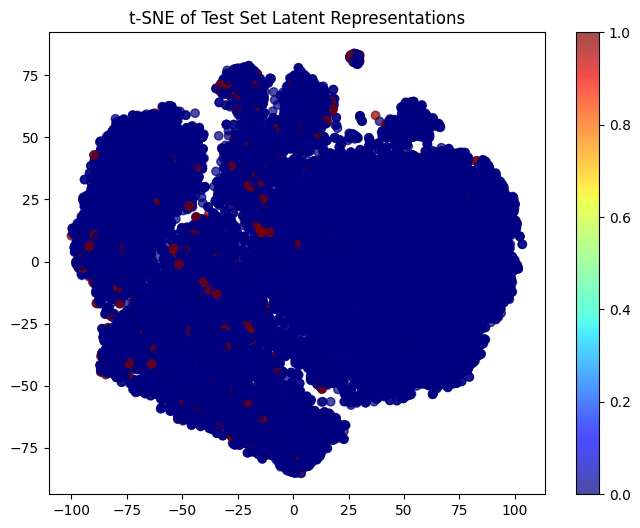

Threshold for anomaly detection: 0.0044


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
csv_file = "./isic2020/isic2020/train.csv"
image_folders = ["./isic2020/isic2020/train"]

df = pd.read_csv(csv_file)

transform = transforms.Compose([])

class SkinLesionDataset(Dataset):
    def __init__(self, df, image_folders, transform=None, train=True):
        if train:
            df = df[df["target"] == 0]  # Train only on normal (benign) images
        self.df = df.reset_index(drop=True)
        self.image_folders = image_folders
        self.transform = transform
        self.missing_images = []

    def find_image_path(self, image_name):
        for folder in self.image_folders:
            image_path = os.path.join(folder, image_name + ".jpg")
            if os.path.exists(image_path):
                return image_path
        return None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_name = row["image_name"]
        label = row["target"]

        image_path = self.find_image_path(image_name)
        if image_path is None:
            self.missing_images.append(image_name)
            print(f"Warning: Image {image_name} not found. Skipping...")
            return self.__getitem__((idx + 1) % len(self.df))
        
        try:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (64, 64))
            image = image / 255.0
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")
            return self.__getitem__((idx + 1) % len(self.df))
        
        return image.to(device), torch.tensor(label, dtype=torch.long).to(device)

# Create Datasets & Loaders
train_dataset = SkinLesionDataset(df, image_folders, transform=transform, train=True)
test_dataset = SkinLesionDataset(df, image_folders, transform=transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*8*8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

# Train AutoEncoder
model = AutoEncoder(latent_dim=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_autoencoder(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            optimizer.zero_grad()
            latent, output = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_autoencoder(model, train_loader)

# Reconstruction Error on Test Set
model.eval()

def compute_reconstruction_errors(model, test_loader):
    reconstruction_errors = []
    labels = []
    with torch.no_grad():
        for images, targets in test_loader:
            _, reconstructed = model(images)
            error = ((images - reconstructed) ** 2).mean(dim=[1, 2, 3]).cpu().numpy()
            reconstruction_errors.extend(error)
            labels.extend(targets.cpu().numpy())
    return reconstruction_errors, labels

reconstruction_errors, labels = compute_reconstruction_errors(model, test_loader)

# Determine Threshold for Anomaly Classification
threshold = np.percentile(reconstruction_errors, 95)

# t-SNE Visualization
latent_vectors = []
true_labels = []

with torch.no_grad():
    for images, targets in test_loader:
        latents, _ = model(images)
        latent_vectors.append(latents.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(latent_vectors)
labels = np.array(true_labels)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='jet', alpha=0.7)
plt.colorbar()
plt.title("t-SNE of Test Set Latent Representations")
plt.show()

print(f"Threshold for anomaly detection: {threshold:.4f}")
